In [1]:
# Needed to switch directory in Google drive so as to import MARL env.
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd
!pip install -r requirements.txt
!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
Obtaining gym_continuousDoubleAuction from git+https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git@c897137cbcc93ca71cbd51c27e683c3298f6562d#egg=gym_continuousDoubleAuction (from -r requirements.txt (line 24))
  Skipping because already up-to-date.
  Found existing installation: gym-continuousDoubleAuction 0.0.1
    Can't uninstall 'gym-continuousDoubleAuction'. No files were found to uninstall.
  Running setup.py develop for gym-continuousDoubleAuction
Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.fcnet_v2 import FullyConnectedNetwork
from ray.rllib.models import Model, ModelCatalog
from ray.rllib.policy.policy import Policy
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ppo.ppo_tf_policy import PPOTFPolicy
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv

tf = try_import_tf()

In [0]:
class CustomModel_1(Model):
    """
    Sample custom model with LSTM. 
    """

    def _lstm(self, Inputs, cell_size):
        s = tf.expand_dims(Inputs, axis=1, name='time_major')  # [time_step, feature] => [time_step, batch, feature]
        lstm_cell = tf.nn.rnn_cell.LSTMCell(cell_size)
        self.init_state = lstm_cell.zero_state(batch_size=1, dtype=tf.float32)
        # time_major means [time_step, batch, feature] while batch major means [batch, time_step, feature]
        outputs, self.final_state = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=s, initial_state=self.init_state, time_major=True)
        lstm_out = tf.reshape(outputs, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation
        return lstm_out
    
    def _build_layers_v2(self, input_dict, num_outputs, options):
        hidden = 512
        cell_size = 256
        #S = input_dict["obs"]
        S = tf.layers.flatten(input_dict["obs"])
        with tf.variable_scope(tf.VariableScope(tf.AUTO_REUSE, "shared"),
                               reuse=tf.AUTO_REUSE,
                               auxiliary_name_scope=False):
            last_layer = tf.layers.dense(S, hidden, activation=tf.nn.relu, name="fc1")
        last_layer = tf.layers.dense(last_layer, hidden, activation=tf.nn.relu, name="fc2")
        last_layer = tf.layers.dense(last_layer, hidden, activation=tf.nn.relu, name="fc3")

        last_layer = self._lstm(last_layer, cell_size)

        output = tf.layers.dense(last_layer, num_outputs, activation=tf.nn.softmax, name="mu")

        return output, last_layer

In [0]:
def make_RandomPolicy(_seed):

    class RandomPolicy(Policy):
        """
        A hand-coded policy that returns random actions in the env (doesn't learn).
        """        
        
        def __init__(self, observation_space, action_space, config):
            self.observation_space = observation_space
            self.action_space = action_space
            self.action_space.seed(_seed)

        def compute_actions(self,
                            obs_batch,
                            state_batches,
                            prev_action_batch=None,
                            prev_reward_batch=None,
                            info_batch=None,
                            episodes=None,
                            **kwargs):
            """Compute actions on a batch of observations."""
            return [self.action_space.sample() for _ in obs_batch], [], {}

        def learn_on_batch(self, samples):
            """No learning."""
            #return {}
            pass

        def get_weights(self):
            pass

        def set_weights(self, weights):
            pass

    return RandomPolicy

In [5]:
# storage for plotting
agt_0_NAV = None
agt_1_NAV = None
agt_2_NAV = None
agt_3_NAV = None
global_hist_stats = None # global var for charts

# RLlib config
num_workers = 1
num_envs_per_worker = 2
sample_batch_size = 32
train_batch_size = 128
num_iters = 100

# Chkpt & restore
local_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/"
chkpt_freq = 10
chkpt = 200
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = True

# CDA_env args
num_agents = 4
num_trained_agent = 2 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 1000 # per episode, -1 in arg.
is_render = False

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-03-25 07:36:03,572	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-25 07:36:03,574	INFO resource_spec.py:212 -- Starting Ray with 6.69 GiB memory available for workers and up to 3.35 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-25 07:36:04,089	INFO services.py:1078 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-03-25_07-36-03_571607_8025/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-25_07-36-03_571607_8025/sockets/raylet',
 'redis_address': '172.28.0.2:25912',
 'session_dir': '/tmp/ray/session_2020-03-25_07-36-03_571607_8025',
 'webui_url': '127.0.0.1:8265'}

In [6]:
# Policies

def gen_policy(i):
    """
    Each policy can have a different configuration (including custom model)
    """
    config = {"model": {"custom_model": "model_disc"},
              "gamma": 0.99,}
    return (None, obs_space, act_space, config)

def policy_mapper(agent_id):
    for i in range(num_agents):
        if agent_id == i:
            return "policy_{}".format(i)


# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i) for i in range(num_policies)}


def set_agents_policies(policies):
    """
    Set 1st policy as PPO & override all other policies as RandomPolicy with
    different seed.
    """
    
    # set all agents to use random policy
    for i in range(num_agents):
        policies["policy_{}".format(i)] = (make_RandomPolicy(i), obs_space, act_space, {})
    
    # set agent 0 & 1 to use None (PPOTFPolicy)
    offset = 2 # num of trained agents
    for i in range(num_agents-offset):
        #policies["policy_{}".format(i)] = (PPOTFPolicy, obs_space, act_space, {})
        policies["policy_{}".format(i)] = (None, obs_space, act_space, {})

    print('policies:', policies)
    return 0


set_agents_policies(policies)
policy_ids = list(policies.keys())

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class '__main__.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class '__main__.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {})}


In [0]:
def on_episode_start(info):
    """
    info["episode"] is a MultiAgentEpisode object.
    """

    episode = info["episode"] 
    print("episode {} started".format(episode.episode_id))

    # hist_data dicts at 100 items max, will auto replace old with new.
    episode.hist_data["agt_0_NAV"] = []
    episode.hist_data["agt_1_NAV"] = []
    episode.hist_data["agt_2_NAV"] = []
    episode.hist_data["agt_3_NAV"] = []            

In [0]:
def on_episode_end(info):
    """
    arg: {"env": .., "episode": ...}
    """

    episode = info["episode"]
    print("on_episode_end episode_id={}, length={}".format(episode.episode_id, episode.length))   
    
    last_info_0 = episode.last_info_for(0)
    last_info_1 = episode.last_info_for(1)
    last_info_2 = episode.last_info_for(2)
    last_info_3 = episode.last_info_for(3)

    episode.hist_data["agt_0_NAV"].append(last_info_0["NAV"])   
    episode.hist_data["agt_1_NAV"].append(last_info_1["NAV"])   
    episode.hist_data["agt_2_NAV"].append(last_info_2["NAV"])   
    episode.hist_data["agt_3_NAV"].append(last_info_3["NAV"])        

In [0]:
def update_global_hist_stats(info):   
    """
    global_hist_stats for plotting.

    Note:
        Incoming data sequence behavior for historical policy rewards in info['result']['hist_stats']:
        
        If 3 env per worker:
        env 1 ready -> [1]
        env 2 ready -> [2, 1]
        env 3 ready -> [3, 1, 2]
    """

    global global_hist_stats 
    global_hist_stats = info['result']['hist_stats']
    
    for k,v in global_hist_stats.items():
        print("global_hist_stats {} : {}".format(k, v))    

In [0]:
def get_max_reward_ind(info):
    """
    Get index of the max reward of the trained policies in most recent episode.
    """

    recent_policies_rewards = []
    i = 0
    offset = 2 # 1st 2 items are non-related
    #num_trained_agent = 2
    for k, v in info['result']['hist_stats'].items():
        if i >= offset and i < offset + num_trained_agent:
            recent_policies_rewards.append(v[0])
        i = i + 1 
    max_reward_ind = np.argmax(recent_policies_rewards)
    return max_reward_ind    

In [0]:
def get_max_reward_policy_name(policies, max_reward_ind):
    """
    Get the policy name of the trained policy with the max reward in most recent episode.
    """

    train_policies_name = []
    i = 0
    #num_trained_agent = 2
    for k,v in policies.items():
        if i < num_trained_agent:
            train_policies_name.append(k)
        i = i + 1
    max_reward_policy_name = train_policies_name[max_reward_ind]
    return train_policies_name, max_reward_policy_name

In [0]:
def _cp_weight(trainer, src, dest):
    """
    Copy weights of src policy to destination policy.
    """
    
    P0key_P1val = {}
    for (k,v), (k2,v2) in zip(trainer.get_policy(dest).get_weights().items(), 
                              trainer.get_policy(src).get_weights().items()):            
        P0key_P1val[k] = v2

    trainer.set_weights({dest:P0key_P1val, 
                         src:trainer.get_policy(src).get_weights()})

    for (k,v), (k2,v2) in zip(trainer.get_policy(dest).get_weights().items(), 
                              trainer.get_policy(src).get_weights().items()):            
        assert (v == v2).all()    

In [0]:
def cp_weight(trainer, train_policies_name, max_reward_policy_name):
    """
    Copy weights of winning policy to weights of other trained policies.
    Winning is defined as getting max reward in the current episode.
    """

    for name in train_policies_name:
        if name != max_reward_policy_name:
            _cp_weight(trainer, max_reward_policy_name, name)   

In [0]:
def on_train_result(info):
    """
    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """

    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True
    
    trainer = info["trainer"] 
    update_global_hist_stats(info)
    max_reward_ind = get_max_reward_ind(info)
    train_policies_name, max_reward_policy_name = get_max_reward_policy_name(policies, max_reward_ind)
    cp_weight(trainer, train_policies_name, max_reward_policy_name)

    print("on_train_result ********** info['result'] {}".format(info["result"]))     
    global agt_0_NAV
    global agt_1_NAV
    global agt_2_NAV
    global agt_3_NAV
    agt_0_NAV = info["result"]["hist_stats"]["agt_0_NAV"]
    agt_1_NAV = info["result"]["hist_stats"]["agt_1_NAV"]
    agt_2_NAV = info["result"]["hist_stats"]["agt_2_NAV"]
    agt_3_NAV = info["result"]["hist_stats"]["agt_3_NAV"]
    print("on_train_result ********** agt_0_NAV {}".format(agt_0_NAV)) 
    print("on_train_result ********** agt_1_NAV {}".format(agt_1_NAV))    
    print("on_train_result ********** agt_2_NAV {}".format(agt_2_NAV))         
    print("on_train_result ********** agt_3_NAV {}".format(agt_3_NAV))                  

In [15]:
# Training

def my_pyAPI_train():    
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": ["policy_0", "policy_1"],
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                     # Samples batches will be concatenated together to a batch of this size,
                                     # which is then passed to SGD.
    config["sample_batch_size"] = sample_batch_size # DEPRECATED_VALUE,
    config["log_level"] = "WARN"
    config["callbacks"] = {"on_episode_start": on_episode_start, 
                           "on_episode_step": None, 
                           "on_episode_end": on_episode_end, 
                           "on_sample_end": None,
                           "on_postprocess_traj": None,
                           "on_train_result": on_train_result,}

    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    if is_restore == True:
        trainer.restore(restore_path) 

    for i in range(num_iters):
        result = trainer.train()
        #print(result["custom_metrics"])
        #print(pretty_print(result))
        print("training loop = i", i)

        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)


# run everything
my_pyAPI_train()            

2020-03-25 07:36:05,398	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-25 07:36:05,537	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
(pid=8114) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32

2020-03-25 07:36:24,218	INFO trainable.py:178 -- _setup took 18.694 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-03-25 07:36:24,220	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-25 07:36:24,578	WARNING trainable.py:210 -- Getting current IP.
2020-03-25 07:36:24,583	INFO trainable.py:416 -- Restored on 172.28.0.2 from checkpoint: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_200/checkpoint-200
2020-03-25 07:36:24,584	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': 200000, '_time_total': 1186.3254613876343, '_episodes_total': 200}


(pid=8114) episode 55064891 started
(pid=8114) episode 1412917595 started
(pid=8114) on_episode_end episode_id=55064891, length=1000
(pid=8114) episode 1482789449 started
(pid=8114) on_episode_end episode_id=1412917595, length=1000
(pid=8114) episode 1736084420 started


2020-03-25 07:36:39,784	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1028424.000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:39,785	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1030329.000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:39,785	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('879175.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:39,790	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('1062072.000000000000000000001')]) via TBXLogger!


global_hist_stats agt_0_NAV : [Decimal('1028424.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1030329.000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('879175.0000000000000000000000')]
global_hist_stats agt_3_NAV : [Decimal('1062072.000000000000000000001')]
global_hist_stats episode_reward : [-187804115.1444264]
global_hist_stats episode_lengths : [1000]
global_hist_stats policy_policy_0_reward : [-22327247.629746743]
global_hist_stats policy_policy_1_reward : [-46252089.22969821]
global_hist_stats policy_policy_2_reward : [-66266483.451151244]
global_hist_stats policy_policy_3_reward : [-52958294.83383013]
on_train_result ********** info['result'] {'episode_reward_max': -187804115.1444264, 'episode_reward_min': -187804115.1444264, 'episode_reward_mean': -187804115.1444264, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -22327247.629746743, 'policy_1': -46252089.22969821, 'policy_2': -66266483.451151244, 'policy_

2020-03-25 07:36:43,156	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1019534.000000000000000000000'), Decimal('1028424.000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:43,158	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('962602.0000000000000000000000'), Decimal('1030329.000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:43,160	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1007481.000000000000000000000'), Decimal('879175.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:43,161	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('1010383.000000000000000000000'), Decimal('1062072.000000000000000000001')]) via TBXLogger!


global_hist_stats agt_0_NAV : [Decimal('1019534.000000000000000000000'), Decimal('1028424.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('962602.0000000000000000000000'), Decimal('1030329.000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('1007481.000000000000000000000'), Decimal('879175.0000000000000000000000')]
global_hist_stats agt_3_NAV : [Decimal('1010383.000000000000000000000'), Decimal('1062072.000000000000000000001')]
global_hist_stats episode_reward : [-157639645.3970242, -187804115.1444264]
global_hist_stats episode_lengths : [1000, 1000]
global_hist_stats policy_policy_0_reward : [-6466638.756909733, -22327247.629746743]
global_hist_stats policy_policy_1_reward : [-79482825.77231422, -46252089.22969821]
global_hist_stats policy_policy_2_reward : [-54268778.41380644, -66266483.451151244]
global_hist_stats policy_policy_3_reward : [-17421402.453993894, -52958294.83383013]
on_train_result ********** info['result'] {'episode_reward_max': -157639645.

2020-03-25 07:36:51,739	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007815.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:51,741	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('936472.0000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:51,748	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1045418.000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:51,752	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('1010295.000000000000000000000'), Decimal('1062072.000000000000000000001'), Decimal('1

global_hist_stats agt_0_NAV : [Decimal('1007815.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('936472.0000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('1045418.000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000')]
global_hist_stats agt_3_NAV : [Decimal('1010295.000000000000000000000'), Decimal('1062072.000000000000000000001'), Decimal('1010383.000000000000000000000')]
global_hist_stats episode_reward : [-150999920.87773234, -187804115.1444264, -157639645.3970242]
global_hist_stats episode_lengths : [1000, 1000, 1000]
global_hist_stats policy_policy_0_reward : [-28987285.454008114, -22327247.629746743, -6466638.756909733]
global_hist_stats policy_policy_1_reward : [-62847711.40626253, -46252089.22969821, -79482825.77231422]
global_his

2020-03-25 07:36:55,170	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1006293.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:55,171	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1004152.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:55,172	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('991275.0000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000'), Decimal('1045418.000000000000000000000')]) via TBXLogger!
2020-03-25 07:36:55,173	WARNING logger.py:221 -- You are trying to log an invalid value 

global_hist_stats agt_0_NAV : [Decimal('1006293.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1004152.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('991275.0000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000'), Decimal('1045418.000000000000000000000')]
global_hist_stats agt_3_NAV : [Decimal('998280.0000000000000000000000'), Decimal('1062072.000000000000000000001'), Decimal('1010383.000000000000000000000'), Decimal('1010295.000000000000000000000')]
global_hist_stats episode_reward : [-56410940.288093425, -187804115.1444264, -157639645.3970242, -150999920.87773234]
global_hist_stats episode_lengths : [1000, 1000, 1000, 1000]
global_hist_stats policy_

2020-03-25 07:37:03,389	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('996755.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:03,394	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1002875.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:03,396	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1000139.000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000'), Decimal('1045418.000000000000000000000'), Decimal('991275.0000

global_hist_stats agt_0_NAV : [Decimal('996755.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1002875.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('1000139.000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000'), Decimal('1045418.000000000000000000000'), Decimal('991275.0000000000000000000000')]
global_hist_stats agt_3_NAV : [Decimal('1000231.000000000000000000000'), Decimal('1062072.000000000000000000001'), Decimal('1010383.000000000000000000000'), Decimal('1010295.000000000000000000000'), Decimal('998280.0000000000000000000000')]
global_hist_stats episode_reward : [

2020-03-25 07:37:06,655	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1011498.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:06,656	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1010810.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:06,657	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1008947.000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000

global_hist_stats agt_0_NAV : [Decimal('1011498.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1010810.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('1008947.000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000'), Decimal('1045418.000000000000000000000'), Decimal('991275.0000000000000000000000'), Decimal('1000139.000000000000000000000')]
global_hist_stats agt_3_NAV : [Decimal('968745.0000000000000000000001'), Decimal('1062072.000000000000000000001'), Decimal('1010383.0000000000000000000

2020-03-25 07:37:14,949	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('972694.9999999999999999999998'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:14,950	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1004171.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:14,951	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1023484.000

global_hist_stats agt_0_NAV : [Decimal('972694.9999999999999999999998'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1004171.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('1023484.000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000'), Decimal('1045418.000000000000000000000'), Decimal('991275.0000000000000000000000'), Decimal('1000139.000000000000000000000'), Decimal('1008947.000000000000000000000')]
global_hist_stats agt_3_N

2020-03-25 07:37:18,270	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('977703.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998')]) via TBXLogger!
2020-03-25 07:37:18,272	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1009219.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:18,272	WARNING logger.py:221 -- You are

global_hist_stats agt_0_NAV : [Decimal('977703.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998')]
global_hist_stats agt_1_NAV : [Decimal('1009219.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('1019112.000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000'), Decimal('1045418.000000000000000000000'), Decimal('991275.0000000000000000000000'), Decimal('1000139.00000000

2020-03-25 07:37:26,563	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1063294.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:26,564	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1022863.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000'), Decimal('1009219.0000000000000

global_hist_stats agt_0_NAV : [Decimal('1063294.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1022863.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000'), Decimal('1009219.000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('930404.0000000000000000000000'), Decimal('879175.0000000000000000000000'), Decimal('1007481.000000000000000000000'), Decimal('1045418.00000000

2020-03-25 07:37:29,885	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('992850.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:29,887	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('974412.0000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.0000000000000

global_hist_stats agt_0_NAV : [Decimal('992850.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('974412.0000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000'), Decimal('1009219.000000000000000000000'), Decimal('1022863.000000000000000000000')]
global_hist_stats agt_2_NAV : [Decimal('1033429.000000000000000000000'), Decimal('879175.000000000

2020-03-25 07:37:38,256	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1016880.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:38,257	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1020942.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.0000000000000

global_hist_stats agt_0_NAV : [Decimal('1016880.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1020942.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000'), Decimal('1009219.000000000000000000000'), Decimal('1022863.000000000000000000000'), Decimal('974412.0000000000000000000000')]
global_hist_st

2020-03-25 07:37:41,570	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1032413.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:41,575	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('965599.0000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.0000000000000

global_hist_stats agt_0_NAV : [Decimal('1032413.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('965599.0000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000'), Decimal('1009219.000000000000000000000'), Decimal('1022863.000000000000000000000'), Decimal('97441

2020-03-25 07:37:49,837	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1006237.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:49,838	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1003009.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.0000000000000

global_hist_stats agt_0_NAV : [Decimal('1006237.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1003009.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000'), Decimal('1009219.000000000000000000000'), Decimal('10228

2020-03-25 07:37:53,186	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005080.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000')]) via TBXLogger!
2020-03-25 07:37:53,189	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('941388.0000000000000000000002'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.00000000000000

global_hist_stats agt_0_NAV : [Decimal('1005080.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('941388.0000000000000000000002'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('1004171.000000000000000000000'), Decimal('10092

2020-03-25 07:38:01,445	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1026297.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000')]) via TBXLogger!
2020-03-25 07:38:01,446	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1035970.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.00000000000000

global_hist_stats agt_0_NAV : [Decimal('1026297.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1035970.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('1010810.000000000000000000000'), Decimal('10041

2020-03-25 07:38:04,811	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('992709.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000')]) via TBXLogger!
2020-03-25 07:38:04,812	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1000570.000000000000000000000'), Decimal('1030329.0000000000000

global_hist_stats agt_0_NAV : [Decimal('992709.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1000570.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('1002875.000000000000000000000'), Decimal('10108

2020-03-25 07:38:13,118	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987547.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:38:13,120	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1021139.0000000000000

global_hist_stats agt_0_NAV : [Decimal('987547.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1021139.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('1004152.000000000000000000000'), Decimal('10028

2020-03-25 07:38:16,437	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000972.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000')]) via TBXLogger!
2020-03-25 07:38:16,438	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats

global_hist_stats agt_0_NAV : [Decimal('1000972.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1001253.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('936472.0000000000000000000000'), Decimal('10041

2020-03-25 07:38:24,722	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('983090.0000000000000000000001'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000')]) via TBXLogger!
2020-03-25 07:38:24,723	WARNING logger.py:221 -- You are trying to

global_hist_stats agt_0_NAV : [Decimal('983090.0000000000000000000001'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1001302.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('962602.0000000000000000000000'), Decimal('93647

2020-03-25 07:38:28,083	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('981858.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001')]) via TBXLogger!
2020-03-25 07:38:28,086	

global_hist_stats agt_0_NAV : [Decimal('981858.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001')]
global_hist_stats agt_1_NAV : [Decimal('1055360.000000000000000000000'), Decimal('1030329.000000000000000000000'), Decimal('96260

2020-03-25 07:38:36,353	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010112.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1010112.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('1027114.000000000000000000000'), Decimal('10303

2020-03-25 07:38:39,723	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('990104.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('990104.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000')]
global_hist_stats agt_1_NAV : [Decimal('97278

2020-03-25 07:38:47,928	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007008.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1007008.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000')]
glo

2020-03-25 07:38:51,217	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('961464.0000000000000000000002'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('961464.0000000000000000000002'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:38:59,411	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998848.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('998848.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:02,683	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1014326.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1014326.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:11,126	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1012560.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1012560.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:14,460	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1030857.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1030857.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:22,715	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('993489.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('993489.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:26,057	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1001248.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1001248.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:34,246	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004852.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1004852.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:37,570	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1017094.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1017094.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:45,888	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1016632.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1016632.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:49,230	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1012611.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1012611.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:39:57,535	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003574.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1003574.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:00,880	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1014011.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1014011.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:09,277	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('941288.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('941288.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:12,602	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('999604.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('999604.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:20,887	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1008223.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1008223.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:24,227	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1017422.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1017422.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:32,528	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('999877.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('999877.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:35,975	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1016846.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1016846.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:44,295	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991022.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('991022.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:47,604	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('999886.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('999886.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:55,818	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002911.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1002911.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:40:59,121	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1028878.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1028878.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:07,495	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('980920.9999999999999999999997'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('980920.9999999999999999999997'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:10,857	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005861.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1005861.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:19,190	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000539.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1000539.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:22,576	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('986390.0000000000000000000001'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('986390.0000000000000000000001'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:30,767	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1046852.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1046852.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:34,203	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007821.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1007821.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:42,438	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005599.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1005599.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:45,945	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013213.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1013213.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:54,231	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007740.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1007740.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:41:57,635	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004627.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1004627.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:06,115	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('959745.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('959745.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:09,458	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1009695.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1009695.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:17,782	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1006646.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1006646.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:21,156	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1016308.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1016308.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:29,514	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1006149.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1006149.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:33,044	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987034.0000000000000000000001'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('987034.0000000000000000000001'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:41,725	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003185.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1003185.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:45,281	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('945209.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('945209.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:53,769	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('925702.9999999999999999999998'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('925702.9999999999999999999998'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:42:57,297	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('963922.9999999999999999999996'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('963922.9999999999999999999996'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:05,932	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('964757.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('964757.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:09,401	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007266.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1007266.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:17,971	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010809.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1010809.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:21,406	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1012737.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1012737.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:29,843	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002613.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1002613.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:33,388	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1009548.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1009548.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:42,082	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1025214.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1025214.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:45,630	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('942545.9999999999999999999999'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('942545.9999999999999999999999'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:54,324	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000860.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1000860.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:43:57,781	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('988422.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('988422.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:06,435	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991825.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('991825.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:10,072	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002631.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1002631.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:18,744	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1011882.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1011882.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:22,255	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('993498.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('993498.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:30,871	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1024888.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1024888.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:34,417	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('989354.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('989354.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:43,050	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1074620.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1074620.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:46,542	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('997521.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('997521.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:55,009	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004784.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1004784.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:44:58,441	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('975062.0000000000000000000002'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('975062.0000000000000000000002'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:06,995	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1016023.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1016023.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:10,502	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('976114.9999999999999999999999'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('976114.9999999999999999999999'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:19,336	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987595.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('987595.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:22,818	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013767.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1013767.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:31,400	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('929329.0000000000000000000002'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('929329.0000000000000000000002'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:34,974	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1019711.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1019711.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:43,453	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1045818.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1045818.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:46,929	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1018696.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1018696.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:55,364	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1060881.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1060881.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:45:58,877	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998364.0000000000000000000001'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('998364.0000000000000000000001'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:46:07,335	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('997851.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('997851.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:46:10,874	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('983701.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('983701.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:46:19,482	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1039632.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('1039632.000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

2020-03-25 07:46:23,032	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('985337.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000')

global_hist_stats agt_0_NAV : [Decimal('985337.0000000000000000000000'), Decimal('1028424.000000000000000000000'), Decimal('1019534.000000000000000000000'), Decimal('1007815.000000000000000000000'), Decimal('1006293.000000000000000000000'), Decimal('996755.0000000000000000000000'), Decimal('1011498.000000000000000000000'), Decimal('972694.9999999999999999999998'), Decimal('977703.0000000000000000000000'), Decimal('1063294.000000000000000000000'), Decimal('992850.0000000000000000000000'), Decimal('1016880.000000000000000000000'), Decimal('1032413.000000000000000000000'), Decimal('1006237.000000000000000000000'), Decimal('1005080.000000000000000000000'), Decimal('1026297.000000000000000000000'), Decimal('992709.0000000000000000000000'), Decimal('987547.0000000000000000000000'), Decimal('1000972.000000000000000000000'), Decimal('983090.0000000000000000000001'), Decimal('981858.0000000000000000000000'), Decimal('1010112.000000000000000000000'), Decimal('990104.0000000000000000000000'), Dec

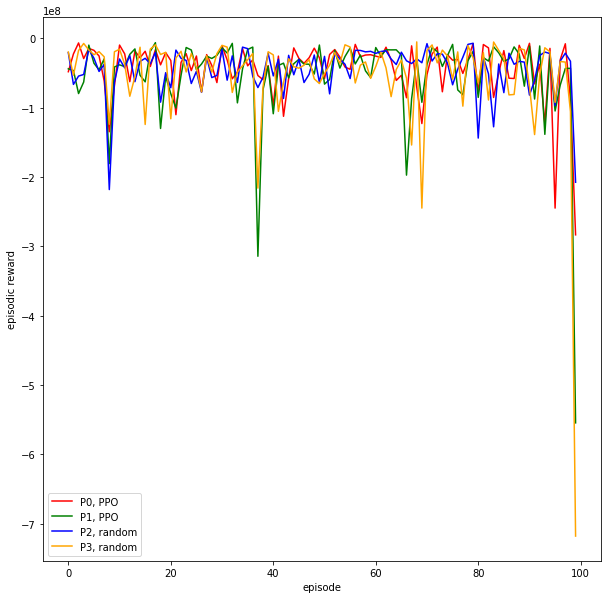

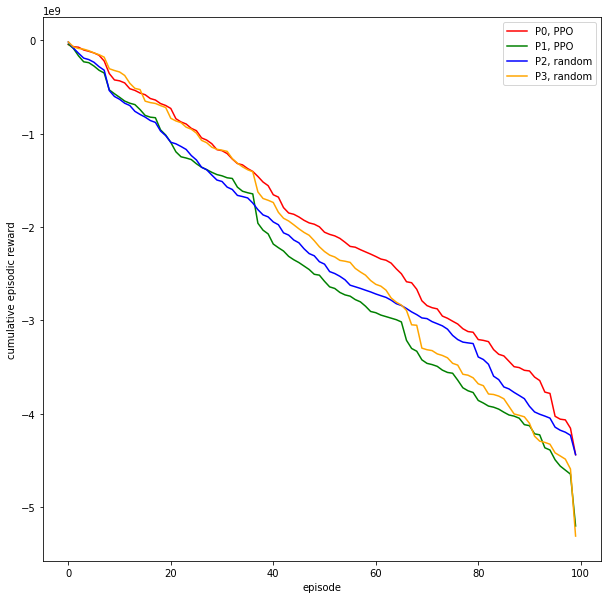

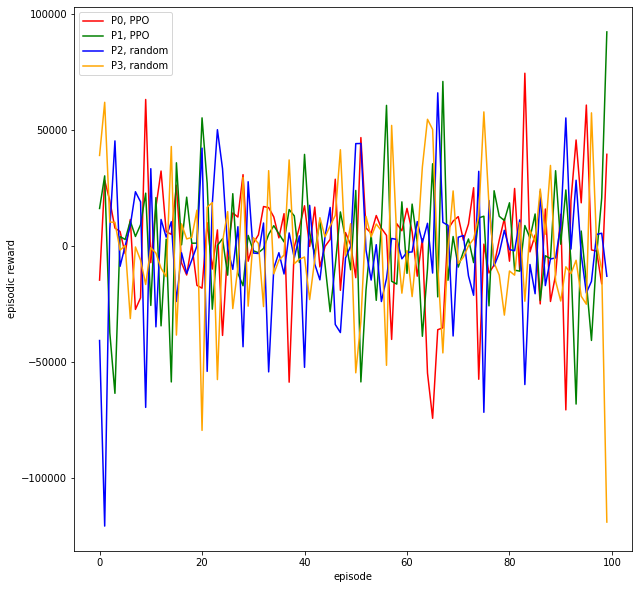

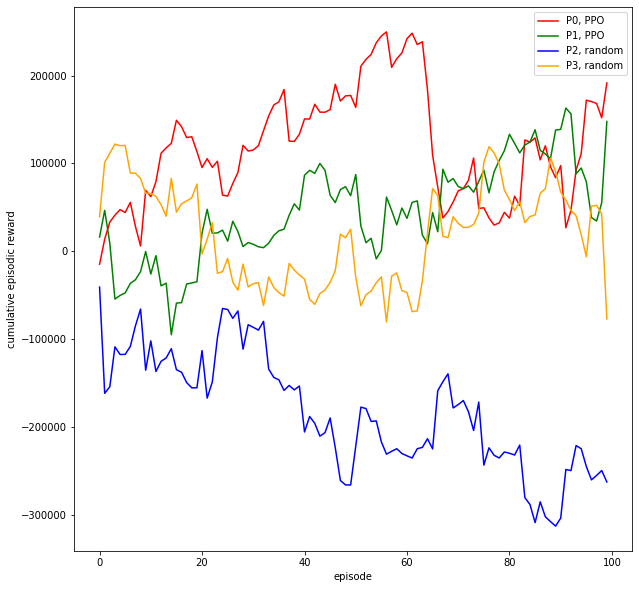

In [16]:
"""
Plot last 100 iterations
"""

import matplotlib.pyplot as plt

def get_policies_hist_rewards(global_hist_stats):
    """
    Get episodic rewards for each agent.
    """

    policies_hist_rewards = []
    i = 0
    offset = 6 # 1st 2 items are unrelated
    num_agent = 4
    for k, v in global_hist_stats.items():
        if i >= offset and i < offset + num_agent:
            policies_hist_rewards.append(v)
        i = i + 1 
    return policies_hist_rewards

def plot_result(x,p0,p1,p2,p3,x_msg,y_msg):

    plt.figure(figsize=(10,10))

    plt.xlabel(x_msg)
    plt.ylabel(y_msg)

    plt.plot(x, p0, 'r', label='P0, PPO') # plotting x, y
    plt.plot(x, p1, 'g', label='P1, PPO') 
    plt.plot(x, p2, 'b', label='P2, random') 
    plt.plot(x, p3, 'orange', label='P3, random') 

    plt.legend()
    plt.show()


policies_hist_rewards = get_policies_hist_rewards(global_hist_stats)

x = range(len(policies_hist_rewards[0]))
p0 = policies_hist_rewards[0]
p1 = policies_hist_rewards[1]
p2 = policies_hist_rewards[2]
p3 = policies_hist_rewards[3]
plot_result(x,p0,p1,p2,p3,'episode','episodic reward')

x = range(len(policies_hist_rewards[0]))
p0 = np.cumsum(policies_hist_rewards[0])
p1 = np.cumsum(policies_hist_rewards[1])
p2 = np.cumsum(policies_hist_rewards[2])
p3 = np.cumsum(policies_hist_rewards[3])
plot_result(x,p0,p1,p2,p3,'episode','cumulative episodic reward')

x = range(len(agt_0_NAV))
p0 = [value - init_cash for value in agt_0_NAV]
p1 = [value - init_cash for value in agt_1_NAV]
p2 = [value - init_cash for value in agt_2_NAV]
p3 = [value - init_cash for value in agt_3_NAV]
plot_result(x,p0,p1,p2,p3,'episode','episodic reward')

x = range(len(agt_0_NAV))
p0 = np.cumsum([value - init_cash for value in agt_0_NAV])
p1 = np.cumsum([value - init_cash for value in agt_1_NAV])
p2 = np.cumsum([value - init_cash for value in agt_2_NAV])
p3 = np.cumsum([value - init_cash for value in agt_3_NAV])
plot_result(x,p0,p1,p2,p3,'episode','cumulative episodic reward')